# Fine Tuning For BERT Models with TPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
Aşağıdaki code ile TPU ya bağlanıyoruz. 

In [2]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.71.10.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.71.10.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [3]:
strategy = tf.distribute.TPUStrategy(resolver) # TPU nun hızından faydalanmak için kullanıyoruz.

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [4]:
# !pip install transformers

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 59.7 MB/s 
     |████████████████████████████████| 596 kB 44.4 MB/s 
     |████████████████████████████████| 6.5 MB 41.4 MB/s 
     |████████████████████████████████| 67 kB 4.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Import Library

In [35]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [36]:
df = pd.read_csv('/content/drive/MyDrive/hepsiburada.csv', encoding="utf-8")

# sample_data içine atmışsak sadece 'hepsiburada.csv' yazmamız yeterli.

In [37]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [38]:
df.Rating.value_counts()

1    229821
0     13676
Name: Rating, dtype: int64

In [39]:
df.Rating = df.Rating.map({1:0, 0:1})

In [40]:
df.Rating.value_counts()

0    229821
1     13676
Name: Rating, dtype: int64

In [11]:
X = df['Review'].values
y = df['Rating'].values

## Tokenization

### Fixing token counts of all documents

https://huggingface.co/dbmdz/bert-base-turkish-cased  linkindeki türkçe kaynaklar üzerinden eğitilmiş bert-base modelini kullandık. 

In [43]:
from transformers import AutoTokenizer  # Tüm modeller için geçerlidir. İçine ilgili BERT model ismini veriyoruz.

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
# Uncased kullanmadık. Hepsini küçük harfli yapıyor. Bu durumda türkçe karekterleri tanımıyor.
# Bundan dolayı cased yapıp türkçe karekterleri secili olsun ve sonra bunları lower yaptık.
# AutoTokenizer içine hangi dile ait olduğunu yazabiliriz.

max_len = 0

# For every sentence...
max_token = []
for sent in X:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(sent.lower(), add_special_tokens=True)
    # Tokenlere dönüştürüyor. Ancak başına ve sonuna özel karekterleri(başına ve sonuna 2-3) ekliyor.
    max_token.append(len(input_ids))

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (758 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  758


Uncase kullansaydık aşağıdaki gibi ayırmazdı. Classification yapacağımızdan dolayı özel isimlerin ayrılmasının bir önemi yok. Çünkü modelimiz bunları birleştirip yeni bir anlam çıkarıyor.

Tokenizer.encode yapınca başına ve sonuna 2 ve 3 ekliyor.

Tüm cümlelere ait tokenlerin boyutu ne ise bunları max_token içine attık. Ancak bunun 512 yi geçmemesi gerekir.

Daha sonra her cümleye ait tokenlerin sayısını sayıyoruz. max_len ile yeni gelen cümlenin uzunluğunu karşılaştırıp hangisi büyükse onu max_len atıyorum yani bunu güncellemiş oluyorum.

Yukarıda bu işlemleri yapınca bize 758 sonucunu verdi ancak bizim 512 yi geçmememiz lazım. Çünkü BERT model 512 den fazla token alamıyor. Bu sebeple verimin büyük kısmını koruyarak ortalama bir token uzunluğu belirlemek istiyorum. 

In [44]:
text = "Şentepeli Şükrü abi?".lower()
 
tokenizer.tokenize(text)

['şen', '##tepe', '##li', 'şük', '##rü', 'abi', '?']

In [45]:
sentence = "Şentepeli Şükrü abi?".lower()
tokens = tokenizer.encode(sentence, add_special_tokens=True)
print(tokens)
print(len(tokens))

[2, 14192, 5364, 2031, 9204, 9025, 13780, 35, 3]
9


In [46]:
sentence = "Şentepeli Şükrü abi?".lower()
tokens = tokenizer.encode_plus(sentence, add_special_tokens=True)
print(tokens)

{'input_ids': [2, 14192, 5364, 2031, 9204, 9025, 13780, 35, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [47]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) < 10)
print(sum(np.array(list) < 10))

[ True False  True  True False False]
3


In [48]:
np.array(max_token).mean()

36.4837390193719

In [49]:
sum(np.array(max_token) < 160) / len(max_token)

# 160 tokende datamın % 99 yakın kısmında herhangi bir bilgi kaybı olmayacak.

0.9877000537994308

!!! Önemli:

Yukarıdaki gibi 160 sayısını alınca tokenlerin neredeyse %99 bilgi kaybı söz konusu olmayacak.

Eğer padding ve truncate işlemlerini yapmak istiyorsam bu durumda encode_plus kullanmam gerekir. BERT modeli kullanmak için input_ids yanında token_type_ids ve attention_mask ihtiyacım var. Sadece encode kullanırsam bana input_ids sayısını verir. Bu sebeple encode_plus kullanıyorum.

Aşağıda for phrase ile her bir yorumu alıyorum, önce bunları küçük harfe çeviriyorum, sonra max_len ile maksimum uzunluğu istenilen rakama sabitliyorum, truncation=True ile maksimum uzunluktan fazla olanları kestiriyorum, max uzunluğa kadar padding yapıyorum ve son olarak da başına ve sonuna özel tokenleri ilave ediyorum. 

Yine for i ile de np.zeros matriksinin ilk satırına buradan alınan input_ids ilave ediyorum. Bu durumda input_ids nin boş kalan kısımlarını 0 lar ile, attention_mask kalan kısımlarını ise 0 la doldurdu. Çünkü bir modele tokeni verirken mutlaka input_ids ile attention_mask belli olması gerekir. Classification işleminde token_type_ids kullanmayacağımızdan dolayı burayı 0 lar ile doldurdu.

Xids, modele vereceğim inputların yani yorumların sayısal hale dönüştürülmüş halidir. 

Xmask ise her bir yorumun gerçek kaç tokenden oluştuğunu gösteriyor. 

Görüldüğü gibi classification işlemlerinde token_type_ids kullanmıyoruz. Sadece input_ids ile attention_mask kullanılıyor. Token_type_ids modele eğer translation için iki farklı dilde cümle verip eğiteceksek bu durumda kullanıyoruz. Hangi dilden hangi dile çevireceğini anlıyor. Classification da bunu ignore ediyoruz.

Sonuçta BERT modele vereceğimiz Xids ve Xmask aynı shape getirip hazırladık.

In [50]:
def transformation(X):
  # set array dimensions
  seq_len = 160
  num_samples = len(X)

  # initialize empty zero arrays
  Xids = np.zeros((num_samples, seq_len))
  Xmask = np.zeros((num_samples, seq_len))

    
  for i, phrase in enumerate(X):
      tokens = tokenizer.encode_plus(phrase.lower(), max_length=seq_len, truncation=True,
                                      padding='max_length', add_special_tokens=True) 
      # assign tokenized outputs to respective rows in numpy arrays
      Xids[i, :] = tokens['input_ids']
      Xmask[i, :] = tokens['attention_mask']
  return Xids, Xmask

In [51]:
Xids, Xmask = transformation(X)

In [52]:
Xids.shape

(243497, 160)

In [53]:
Xmask.shape

(243497, 160)

In [54]:
sentence = "Şentepeli Şükrü abi?".lower()
tokens = tokenizer.encode_plus(sentence.lower(), max_length=20, truncation=True,
                                      padding='max_length', add_special_tokens=True)
print(tokens)

{'input_ids': [2, 14192, 5364, 2031, 9204, 9025, 13780, 35, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [55]:
np.zeros((10, 10))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [56]:
Xids

array([[2.0000e+00, 2.3000e+01, 5.1420e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.3000e+01, 5.1420e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 2.7820e+03, 3.1200e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.0000e+00, 3.8070e+03, 9.2500e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 3.1560e+03, 4.1650e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 1.6807e+04, 1.9870e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [57]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
#from tensorflow.keras.utils import to_categorical

#l = np.array([1, 0, 2, 3, 4])
#to_categorical(l, 5) 

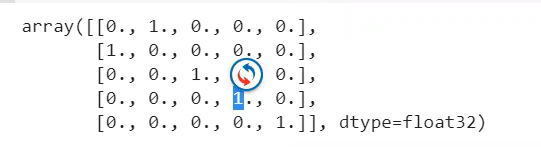

Modele vereceğimiz input ve shapeni tanımladıktan sonra şimdi ise modelden alacağımız outputu da tanımlamamız gerekir. Yukarıdaki code çalıştırınca yukarıdaki gibi bir sonuç alıyoruz. Mesela 1 göstermek için ilk satırda 2.elemanı 1, 2.satırda 0 göstermek için ilk elemanı 1 yapmış gibi düşünebiliriz. 

Binary olduğunda tek satırlı bir array olması için reshape ile aşağıdaki şekle dönüştürdük.

In [58]:
np.array([1, 0, 1, 0, 0]).reshape(-1,1) #reshape(5,1)

array([[1],
       [0],
       [1],
       [0],
       [0]])

In [60]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [61]:
labels = y.reshape(-1,1)
labels

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

!!! Çok Önemli:!!!

Tensor, matriks ve vektörlerden oluşan düzeneğe denir. Burada Xids, Xmask, labels olmak üzere 3 tane matriksim var. 

Bunları modelin istediği tensor formatına dönüştüreceğiz.

Benim her yorumumu satır satır modele versin diye from_tensor_slices kullanıyoruz. 

Ancak modelim Xids, Xmask ve labelslardan hangisi input hangisi output bunu bilmiyor. Bunları modele tanıtmam lazım. Bunu dict içinde belirtiyoruz. Dict dışında kalan kısım output oluyor ve bunu tekrar tanımlamaya gerek yok. Ve bunları tokenizer içinde geçtiği gibi yazmamız çok önemli. Aksi takdirde modelimiz çalışmaz. 

Benim her yorumu satır satır modele vermem gerektiğinden dolayı aşağıdaki gibi tf.data.Dataset.from_tensors((Xids, Xmask, labels)) şeklinde verirsem tüm yorumları olduğu gibi modele vermem demektir ki buda hatalı bir yaklaşımdır. Bunu kullanmayacağız.

In [65]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels)) # tf.data.Dataset.from_tensors((Xids, Xmask, labels))
dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

!!!***** Çok Önemli:******

Aşağıda dict içine koymak çok önemli çünkü hangisi input hangisi output bunu bilmesi gerekir aksi takdirde modelimiz çalışmaz. 

Tokenizer içinde geçen şekilde buraya koymak çok önemli.

In [120]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

def map_func(Xids, Xmask, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Xids, 'attention_mask': Xmask}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

In [121]:
dataset

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(160,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(160,), dtype=tf.float64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

## Train Test Split

!!! Çok Önemli:
    
TF documanlarında; bir datayı BERT modele hazırlarken mutlaka batchsize 16 veya 32 alınmalıdır şeklinde tavsiye edilir.

Yukarıda TensorSpec(shape=(160,)) içine verdiğimizde tüm satırların gözükmemesinin sebebi BERT modelinin buna satır satır işlem yapacağını göstermek için.

Shuffle ile datayı kendi içinde karmak istiyoruz.

Aşağıdaki gibi shuffle içine buffersize yerine satır sayısından büyük bir sayı yazarken en mükemmel karışımı elde ederiz şeklinde bir ifade vardır dokümanında. Bundan dolayı 243500 yazdık.

reshuffle_each_iteration ise bizim train ve test setlerini alıp kontrol edebilmek için bunun mutlaka false olması lazım. Aksi takdirde yani true olursa train ve test seti karışır yani test seti ilk iterasyonda ilk 100 satır ise ikinci iterasyonda ise o 100 satır train seti olabilir. Normalde default değeri True dur.

Batch ile paketlere bölüyoruz. Batch işlemini daha önce fit sırasında yaparken BERT modellerinde bunu datasetini oluştururken veriyoruz.

drop_remainder True yazarsak modele kaçlı paketlere böldüğümüz hatırlatmamız gerekir. False olursa none yazar ve kaçlı paketlere böldüğü bilmez. Burada 32 li paketler halinde vereceğiz.

Train ve test setini dataset içinden ayırmak gerekir. BERT modellerinde genellikle kullanılan 0.9 yani % 90 dır.

Aşağıda satır sayısını/batchsize bölünce len dediğimde artık bana satır sayısını değilde paketlerin sayısını sayacak.

BERT modellerde genellikle split % 90 dur. 32 li paketlerin % 90 nu traine geri kalan % 10 ise test setine atayacağım. Küsuratlı sayı çıkarsa bunu int. yapınca oraya yuvarlar. Xtrain ve y train gerek yok çünkü yukarıda tanımladığımız dict içindekiler Xtrain, dışındakiler ise y traindir.

val_ds = dataset.skip(size) ile traine ayrılan dışında kalanları datasetinden validation ds atar. Train dışında kalan % 10 luk kısmı vermiş olduk.

In [122]:
batch_size = 32

# shuffle and batch
# fit into a batch of 32
dataset = dataset.shuffle(243500, reshuffle_each_iteration=False).batch(batch_size, drop_remainder=True)

In [123]:
dataset

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(32, 160), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(32, 160), dtype=tf.float64, name=None)}, TensorSpec(shape=(32, 1), dtype=tf.int64, name=None))>

In [124]:
# set split size (90% training data) and calculate training set size
split = 0.9
size = int(len(dataset)*split) #int((Xids.shape[0]/batch_size)*split)

# get training and validation sets
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [72]:
print(len(dataset))
print(len(dataset)*0.9)
print(int(len(dataset)*0.9))

7609
6848.1
6848


In [74]:
Xids.shape

(243497, 160)

In [75]:
#batch_size=32
int(Xids.shape[0]/batch_size)

7609

## Adamw optimization

!!! Önemli:****

BERT modellerinin bu kadar iyi skor almasının sebebi Adamw optimizeridir. 

Optimizer bizim loss minimize etmeye yarayan bir algoritmadır. 

Burada öncelikle aşağıdaki kodun install edilmesi gerekir. Epoch sayısı başlangıçta verilir. Yani 32 li paketlerden kaç tane verilecek. 

loss değerini min. etmeye çalışırken train datasetinin % 90 luk kısmı ile eğitiyor ve % 10 luk kısmı yani warmup ile score alarak bunun ile karşılaştırır. Loss değerinin min.olma durumunu sürekli karşılaştırmış olur. Yani % 90 luk kısmı ile eğitir ve % 10 luk kısmı ile test skoru alarak loss değerinin min. ne kadar yaklaşmış bunu sürekli kontrol ediyor. Bu min değeri maksimize etmeye çalışıyor. 

Overfitting olsun veya olmasın learning_rate için 3 tane aşağıdaki gibi 2e-5, 3e-5, 5e-5 değerlerinden birinin kullanılması önerilir Google kendi dokümanlarında.

BERT modelleri için epoch sayısı mutlaka 1,2 ve 3 olmalı diye yazar. Daha fazlası modelimizi overfittinge götürür.

In [78]:
# !pip install -q tf-models-official  

# Scoreları iyileştirmeye yarıyor.
# Optimization içinde ilave bir eğitim gibi düşünebiliriz.
# Çok fazla hata alındığından dolayı bunu kullanmak çok tercih edilmiyor ancak aşağıda yapılan işlem ile hata alınması engellenmiş oluyor.

In [ ]:
len(train_ds)

In [125]:
from official.nlp import optimization 
epochs = 1  # 2,3
#batch_size = 32
steps_per_epoch = len(train_ds)

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5  # 3e-5, 5e-5
optimizer= optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')      

## Creating Model

!!!! Çok Önemli:****

from transformers import TFAutoModel Mutlaka bir func. içinde tanımlamamız lazım ki TPU nun hızından yararlanalım.

Bütün BERT modelleri için TFAutoModel için kullanabiliriz. Ancak başında TF olması önemli çünkü biz bu TF library kullanan BERT modellerini kullanmak istiyoruz.

from transformers import TFAutoModel bunu mutlaka func. içinde tanımlamak gerekir.

Dokümanlarda BERT modelleri için Epoch sayısı 1,2 veya 3 olmalı der. Daha fazlası overfittinge sebep oluyor. 

Burada ayrıca mutlaka yukarıda kullandığımız isimlere inputs _ids ve attention_mask isimlerini vermemiz gerekir.

BERT modeller int32 ile çalıştığından dolayı burada dönüştürdük. Datasetinde float olduğundan dolayı aksi takdirde float hatası verir. 

Attention mask input olduğunu algılaması için yukarıdaki isimle aynı şekilde verilmesi gerekir.

Shape içine yazdığımız token sayısı kadar parametre sayısı artar ve işlem süresi uzar. Bundan dolayı 512 vermemiz maliyeti artırır. Çoğu notebookta buraya 512 verilmiş ve geçilmiştir.

BERT modelinin en sonunda pooler output diye bir layer vardır. Bu layerda BERT modelinin kendi içindeki tokenleri eğitilmiş ve bir wordembeddinge dönüştürülmüştür. Artık bunların eğitime ihtiyacı yok. Bunlar diğer tokenler ile çok iyi ilişki kurabiliyor. BERT in en son katmanındaki pooler_outputtan kendi corpusum içindeki tokenlere karşılık gelecek wordembeddingleri çekeceğim. 

Buradan çektiğim embeddingsleri dense layer aktarıyorum.

Google Developerler dropout değeri olarak 0.1 kullanmayı tavsiye ediyorlar ancak burada yeterli olmadığından dolayı 0.2 kullandık.

Son olarak da embeddinglayerdan aldığım değerleri dense layere aktarıp output alıp y ye aktardık.

Sonunda modeli tam olarak tanımlamam gerekir yoksa hata alırım.

Binary olduğundan dolayı activation func. olarak Sigmoid func. kullandım.

RNN modellerde bir token sayısı az ise alacağımız sonuclar düşük olabilir ancak BERT modeller dengesiz data setlerinde ve token sayısının az olduğu durumlarda bile wordembeddinge dönüştürerek cok daha iyi scorlar alır.

Aşağıdaki gibi inputları [] içinde vermemiz gerekir.

In [127]:
def create_model():
    from transformers import TFAutoModel
    model = TFAutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")
    input_ids = tf.keras.layers.Input(shape=(160,), name='input_ids', dtype='int32') # isimler dataset ile aynı olacak.
    attention_mask = tf.keras.layers.Input(shape=(160,), name='attention_mask', dtype='int32')  # isimler dataset ile aynı olacak.

    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] #[1]

    x = tf.keras.layers.Dense(160, activation='relu')(embeddings)
    x = tf.keras.layers.Dropout(0.2, name="dropout")(x)  # 0.1 tavsiye edilen.
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(x)

    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)

Yukarılarda TPU oluşturduktan sonra bunu strategy diye bir değişkene atamıştık.  

In [128]:
with strategy.scope():
  
  optimizer = optimizer #tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
  loss = tf.keras.losses.BinaryCrossentropy()
  recall = tf.keras.metrics.Recall() # neyi takip etmek istiyorsak yazıyoruz.
  model3 = create_model() # modeli oluştururken yukarıdaki func.mutlaka tanımlamamız gerekir.
  model3.compile(optimizer=optimizer, loss=loss, metrics=[recall])

Some layers from the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


!!! Çok Önemli:

Ağırlıklandırma yapmak istersek aşağıdaki kodları çalıştırabiliriz. Önce 0 ve 1 class oranlarını belirleyip daha sonra bunlara ters oranları veriyoruz. 0 olumlu yorum, 1 olumsuz yorumlar.

BERT modellerde sample_weight kullanamayız yoksa hata alırız. Sadece class_weight kullanabiliriz. Aşağıdaki history = model3.fit(train_ds, validation_data= val_ds, epochs=epochs) içine class_weight=weights ile tanımlayabiliriz.

Ancak BERT modeller çok iyi eğitildiği için ağırlıklandırma kullanmaya gerek olmayabilir.

In [ ]:
# pd.Series(y).value_counts(normalize=True)

0    0.943835
1    0.056165
dtype: float64

In [ ]:
# weights = {0:0.05, 1:0.95}

In [129]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 160)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 160,                                         

X_train ve Y_train yok onun yerine train_ds ve validation_data seti Xtrain ve Ytrainden oluşuyormuş gibi düşünebiliriz. Xids ve Xmask benim Xtrain, Output ise benim ytrainmiş gibi düşünebiliriz.

!!! Dikkat!!!!!

Aşağıdaki işlemi kendi localimizde yaparsak kendi localimizde yaklaşık 180 saat sürmesi beklenir. CPU da bu 4 saat sürerken TPU 15 dk civarı tutmaktadır.

In [130]:
history = model3.fit(
    train_ds, validation_data= val_ds,
    epochs=epochs)

6848/6848 [==============================] - 670s 87ms/step - loss: 0.0902 - recall_5: 0.6676 - val_loss: 0.0623 - val_recall_5: 0.7718


## Model evaluation

Bu kadar dengesiz bir veri setinde alınan skorların aşağıda çok iyi olduğunu söyleyebiliriz. Daha sonra ise class_weight yaptığımızda ise skorların daha da iyileştiğini görüyoruz.

!!! ÇOK ÖNEMLİ:

val_ds çalıştırdığımızda 32 li paketler halinde bilgi verir. Bunu for loop sokarak içeriğine bakıyoruz. Bunun ile val_ds içindeki y trueları çekiyoruz.

print(np.array(i)) çalıştırdığımızda bana input_ids ile attention_mask döndürdü. Bunlar ilk kısım yani i[0] oluyor. Yani modelin input değerlerini döndürür. i[1] ise bana output döndürür. Bunu arraya çevirmezsem tensor şeklinde verir ve buda hem yer kaplar hem de çalışma zamanının artırır.

Bu arraya dönmüş 32 li paketleri tekrar bir for loop ile alarak y trueları buluyorum. Bunları y_test içine atıyoruz.

In [131]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model3.predict(val_ds) >= 0.5

y_test = []
for i in val_ds:
 for j in np.array(i[1]):
    y_test.append(j)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     22928
           1       0.89      0.77      0.83      1424

    accuracy                           0.98     24352
   macro avg       0.94      0.88      0.91     24352
weighted avg       0.98      0.98      0.98     24352



In [132]:
y_train_pred = model3.predict(train_ds) >= 0.5

y_train = []
for i in train_ds:
  for j in np.array(i[1]):
    y_train.append(j)

print(classification_report(y_train, y_train_pred)) 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    206884
           1       0.93      0.82      0.87     12252

    accuracy                           0.99    219136
   macro avg       0.96      0.91      0.93    219136
weighted avg       0.99      0.99      0.99    219136



In [ ]:
val_ds  # İçindeki gerçek y değerlerini çekmem gerekir.

# i[0] bana input_ids ve attention_mask döndürür.
# i[1] dersemde bana output döndürür.
# hızlandırmak için array çevirdik. 
# daha sonra gerçek değerleri alıp y_test içine attım ve bunu da y_pred ile karşılaştırdım.

In [115]:
for i in val_ds:
  print(np.array(i[1]))
  break

[[0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


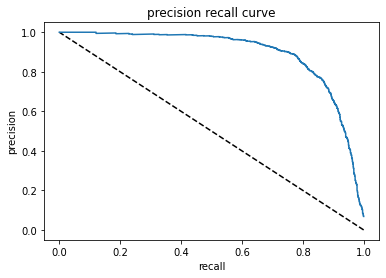

In [168]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_pred_proba = model3.predict(val_ds)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot([1,0],[0,1],'k--')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

Görüldüğü gibi bu kadar dengesiz bir datasetinde 1 class yani olumsuz yorumlar için aldığımız skorun ne kadar iyi olduğunu görüyoruz.

In [169]:
average_precision_score(y_test, y_pred_proba)

0.8937896633491915

In [133]:
model3.save("sentiment_model_without_weighted.h5")

In [ ]:
!pip install -q tf-models-official  

!!!! Çok Önemli: 

Modeli kaydettikten sonra daha önce optimizationu import ederken istall ettiğimiz !pip install -q tf-models-official  tekrar install etmemiz gerekir.

Daha sonra ise aşağıdaki custom_objects mutlaka yazmamız gerekir. Drive kaydedip çekerken model4 olarak kaydettim.

In [134]:
import tensorflow as tf
import official.nlp.optimization as adamw
from tensorflow.keras.models import load_model

model4 = load_model('/content/drive/MyDrive/sentiment_model_without_weighted.h5', custom_objects={'AdamWeightDecay':adamw.AdamWeightDecay})

!!! Önemli:

Artık tahmin alırken daha önceden yaptığımdan farklı olarak return_tensors='tf' ile TF formatında tensore dönüştür diyorum.

İlave olarak daha önceden yaptığım import ve tokenizers tanımlama işlemlerini tekrar burada yeniden yapmam lazım.

In [135]:
# initialize tokenizer from transformers
from transformers import AutoTokenizer, TFAutoModel

tokenizers = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")

def prep_data(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizers.encode_plus(text.lower(), max_length=160,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True,
                                   return_tensors='tf')
  
    return {'input_ids': tokens['input_ids'],      #tf.cast(tokens['input_ids'], tf.int32)
            'attention_mask': tokens['attention_mask']} #tf.cast(tokens['attention_mask'], tf.int32)

In [162]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün aynı gün elime geçti"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler"
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "bu kargoyu biran önce bırakın. yoksa üründe sıkıntı yok"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik. "
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün. Teşekkürler '
review15 = "alınca anlarsın anyayı konyayı"
review16 = "çöpe atacak paran varsa alabilirsin"
review17= "Telefon fena değil"
review18 = "al da gününü gör"
review19 = "Ürün süper ama satıcı ve kargo berbat"
review20= "kargo süper ama ürün berbat"
review21 = "Aldigim TV cok kaliteli diye dusunmustum, sonradan cok da iyi bir TV olmadigini dusundum, ama neyse yine de memnunum."
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14, review15, review16, review17, review18, review19, review20, review21]

Aşagıdaki gibi her bir yorumu çağırıp bunları tensor içine attım. Daha sonra herbir tensor ile model4 üzerinden predict yaptım. 

Bunların olasılıklarını prob diye bir liste kaydettim. Daha sonra olasılığı 0.5 ten büyük olanları 1 classa diğerlerini ise 0 classa atadım.

In [163]:
probs = []
for i in reviews:

  in_tensor = prep_data(i)

  prob = model4.predict(in_tensor)[0][0] # İki boyutlu array. Tek sıfır bir boyuta düşürür. İkinci sıfır ise içindeki değeri alır. 

  probs.append(prob)

In [164]:
probs

[0.0003810227,
 0.0005427003,
 0.9920132,
 0.0007711947,
 0.64404666,
 0.9890535,
 0.00067192316,
 0.9847493,
 0.0004197657,
 0.9918319,
 0.00061059,
 0.023808539,
 0.9538698,
 0.004017502,
 0.005593151,
 0.08763188,
 0.24691695,
 0.004234612,
 0.019344598,
 0.9161774,
 0.0068587065]

In [165]:
classes  = (np.array(probs) >= 0.5).astype("int")
classes

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [166]:
my_dict = {"Review":reviews, "prob":probs, "classes":classes}

In [167]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(my_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Review,prob,classes
0,çok beğendim herkese tavsiye ederim,0.000381,0
1,süper ürün aynı gün elime geçti,0.000543,0
2,büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım,0.992013,1
3,kelimelerle tarif edilemez,0.000771,0
4,tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten,0.644047,1
5,hiç resimde gösterildiği gibi değil,0.989053,1
6,kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler,0.000672,0
7,hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum,0.984749,1
8,tam bir fiyat performans ürünü,0.000420,0
9,beklediğim gibi çıkmadı,0.991832,1


Yukarıdaki alınca anlarsın anyayı konyayı ile al da gününü gör yorumlarını model çok başarılı olsa da yani tokenler arasındaki anlamsal ilişkileri çok iyi yapsa da train kısmında yani corpusta yani datasetimde bu yorumlar hiçbir şekilde geçmediği için bunları öğrenememiş ve yanlış classification yapmış.

!!! HuggingFace!!!

huggingface.co da anasayfada pricing yanındaki 3 çizgiden course seçiyoruz. 
Sol taraftan 1.Transformers Models den, what can they do? tıklıyoruz. 
Sonra ortadaki open in colab segmesine basıyoruz. 

https://huggingface.co/course/chapter1/3?fw=pt  den open in colab te açtık. Transformersları install ettik. Bana bir pipeline oluşturuyor. Bu pipeline ile hazır modelleri seçip kullanabiliyoruz. Model isimlerini pipeline içine veriyoruz.

Huggingface üzerinde; 

sentiment analysis, 

zero-shot-classification(Burada istediğimiz labelları yani classları girince classifier içine [] içinde girdiğimiz metnin bunlara ne kadar ait olduğuna ilişkin skor döndürüyor. Burada ayrıca birden fazla cümle girince bunları candidate_labels=[] içinde göstermemiz gerekir.), 

text-generation(cümlenin başını veriyoruz geri kalanı kendisi dolduruyor.),

"text-generation", model="distilgpt2"(burada max cümle uzunluğu ve kaç cümle olacağını belirtiyoruz), 

fill-mask(verilen cümledeki <mask> içine corpusumdaki 30-40 bin token arasından hangisinin geleceği ile ilgili bir olasılık döndürüyor.), 

"ner", grouped_entities=True(corpusumdaki yer, organizasyon isimlerini bulmada, healtcare tespitinde, kandaki protein değerlerini yakalamada, testte geçen ilaç isimlerini yakalamada veya kimyasal terimleri yakalamada)

"question-answering"(birden fazla soru soracaksak [] içine almamız gerekir, verdiğimiz metne yani contexte göre sorduğumuz soruya cevap veriyor),

"summarization"(summarizer içine texti veriyoruz ve bize özet çıkarıyor. Bu işlemi keywordleri buluyor ve bunlar üzerinden özeti çıkarıyor.),

"translation", model="Helsinki-NLP/opus-mt-fr-en" (seçtiğimiz dilde çeviri yapıyor ancak Google translate kadar mükemmel değil.)

!!! Önemli:****

Model seçmek için huggingface.io sayfasında üst tarafta yazan Models giriyoruz. 
Sol tarafta açılan Taska tıklayınca aşağıdaki modellerden birini seçebiliriz. 
Modelin üzerine tıklayıp sağda açılan alandan modelin encoderine seçip modeli çalıştırıyoruz. 

['audio-classification', 'automatic-speech-recognition', 'conversational', 'feature-extraction', 'fill-mask', 'image-classification', 'image-segmentation', 'ner', 'object-detection', 'question-answering', 'sentiment-analysis', 'summarization', 'table-question-answering', 'text-classification', 'text-generation', 'text2text-generation', 'token-classification', 'translation', 'zero-shot-classification', 'zero-shot-image-classification', 'translation_XX_to_YY']"


Aşağıdaki gibi önce task kısmına hangi modeli kullanacaksam, model yerine de modelin ismini kopyalayıp yapıştırıyorum.

from transformers import pipeline

translator = pipeline(task="text-classification", model="nlptown/bert-base-multilingual-uncased-sentiment")
translator("I love you too much.")

huggingface kullanırken yan tarafta altta açılan nasıl kullanıldığına ilişkin demolara da bakmakta fayda var. 

SPARK NLU kütüphanesinden NLP hususunda devam etmek istersek çok faydalı olabilir.


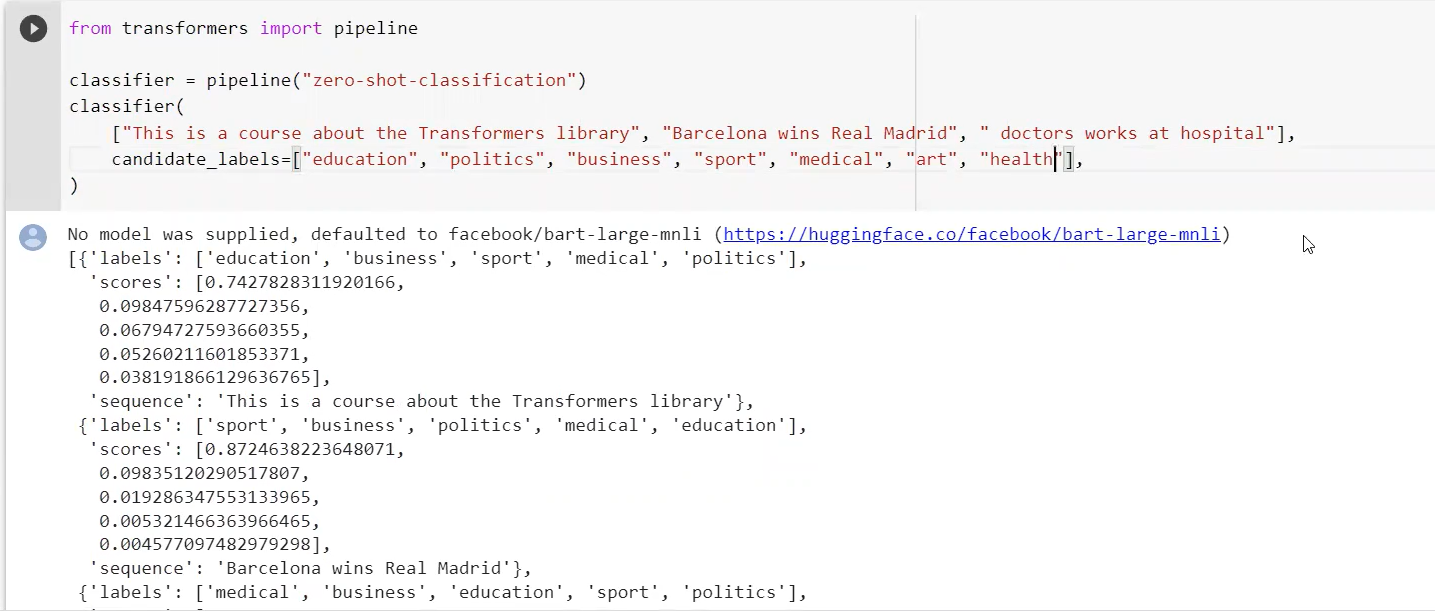

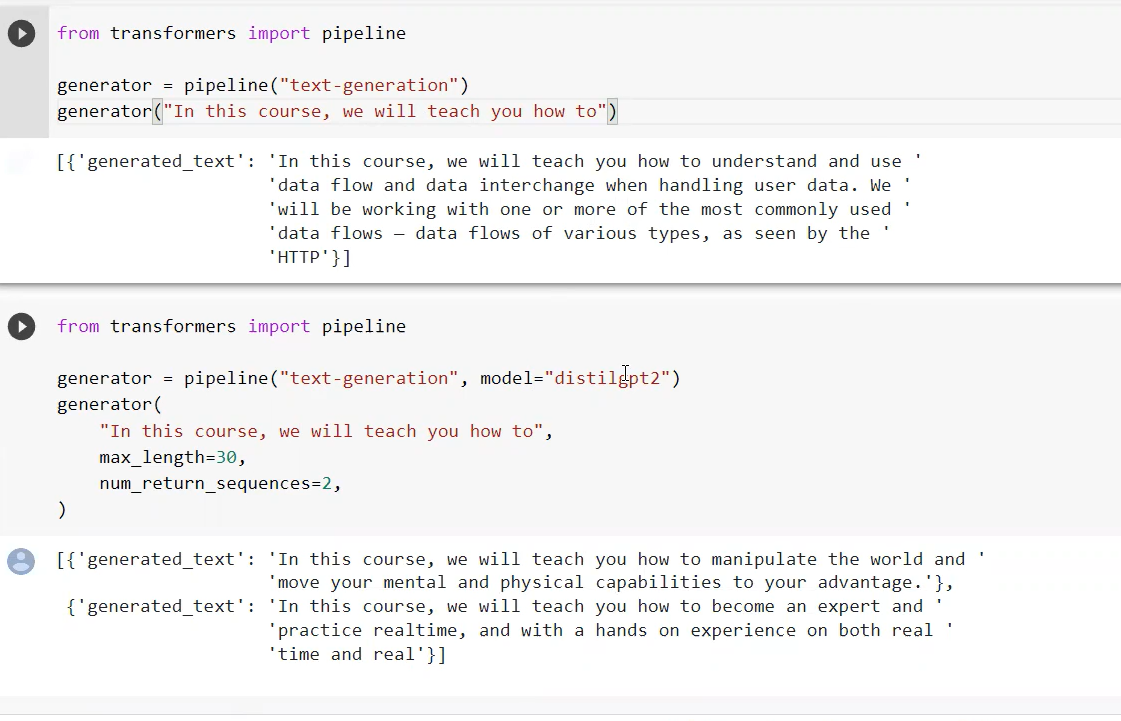

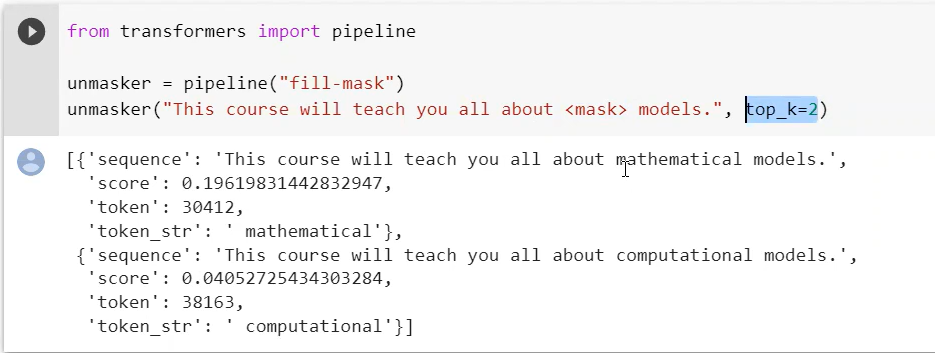

Sentence Similarity çok fazla kullanılmaktadır.

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')
embeddings = model.encode(sentences)
print(embeddings)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity([embeddings[0]], embeddings[1:]) # cosine_similarity 2 boyutlu istediği için [[]] içine aldık.

In [ ]:
sentence = ["How old are you?", "What is your age?"]
embeddings = model.encoder(sentences) # önce embeddings dönüştürdük.
cosine_similarity([embeddings[0]],embeddings[1:])